In [4]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [5]:
pd.read_csv('action1_processed/action1.csv').head()

,lh,rh,ls,rs,w,ll,rl,1x,1y,2x,...,21x,21y,22x,22y,23x,23y,24x,24y,25x,25y
0,0,0,2104,6495,289,0,370,1001.090,224.108,998.361,...,1113.03,1015.90,1051.21,977.727,833.350,998.114,827.522,977.748,892.342,965.911
1,0,0,2595,6472,288,0,371,998.301,233.068,998.183,...,1110.15,1015.89,1051.20,980.579,821.632,998.192,815.856,980.623,895.222,968.837
2,0,0,1987,6502,286,0,370,998.301,233.068,998.183,...,1110.15,1015.89,1051.20,980.579,821.632,998.192,815.856,980.623,895.222,968.837
3,0,0,2152,6620,285,0,370,998.290,235.914,998.241,...,1110.13,1015.91,1048.35,977.770,818.732,998.183,815.843,980.596,895.207,968.786
4,0,0,2373,5716,282,0,368,998.338,235.914,998.328,...,1110.14,1015.91,1048.41,977.806,818.758,998.214,815.848,980.633,895.233,965.924


In [64]:
train_x = []

# Store csv file in a Pandas DataFrame
df = pd.read_csv('action1_processed/action1.csv')

# Scaling the input data
sc = MinMaxScaler()
label_sc = MinMaxScaler()
data = sc.fit_transform(df.values)

# Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
label_sc.fit(df.iloc[:,7:57].values.reshape(-1,1))
print(label_sc.shape)

AttributeError: 'MinMaxScaler' object has no attribute 'shape'

In [35]:
# Define lookback period and split inputs/labels
lookback = 10
inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
labels = np.zeros((len(data)-lookback,50))
print(inputs.shape)
print(labels.shape)
for i in range(lookback, len(data)):
    inputs[i-lookback] = data[i-lookback:i]
    labels[i-lookback] = data[i][7:57]
inputs = inputs.reshape(-1,lookback,df.shape[1])
labels = labels.reshape(-1,50)
print(inputs.shape)
print(labels.shape)

(3367, 10, 57)
(3367, 50)
(3367, 10, 57)
(3367, 50)


In [36]:
# Split data into train/test portions and combining all data from different files into a single array
test_portion = int(0.1*len(inputs))
train_x = inputs[:-test_portion]
train_y = labels[:-test_portion]
test_x = inputs[-test_portion:]
test_y = labels[-test_portion:]

In [46]:
batch_size = 10

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
input_dim = next(iter(train_loader))[0].shape
print(input_dim)

torch.Size([10, 10, 57])


In [47]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [48]:
print(device)

cpu


In [49]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [50]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 50
    n_layers = 2
    # Instantiating the model
    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            h = h.data
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            #if counter%20 == 0:
            print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model


In [51]:
def evaluate(model, test_x, test_y, label_sc):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    
    inp = torch.from_numpy(np.array(test_x))
    labs = torch.from_numpy(np.array(test_y))
    h = model.init_hidden(inp.shape[0])
    out, h = model(inp.to(device).float(), h)
    outputs.append(label_sc.inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    targets.append(label_sc.inverse_transform(labs.numpy()).reshape(-1))
    
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [52]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")

Starting Training of GRU model
Epoch 1......Step: 1/303....... Average Loss for Epoch: 0.3210621178150177
Epoch 1......Step: 2/303....... Average Loss for Epoch: 0.29572588205337524
Epoch 1......Step: 3/303....... Average Loss for Epoch: 0.27231544256210327
Epoch 1......Step: 4/303....... Average Loss for Epoch: 0.2419430911540985
Epoch 1......Step: 5/303....... Average Loss for Epoch: 0.21058094948530198
Epoch 1......Step: 6/303....... Average Loss for Epoch: 0.18632695575555167
Epoch 1......Step: 7/303....... Average Loss for Epoch: 0.17063652724027634
Epoch 1......Step: 8/303....... Average Loss for Epoch: 0.15722214058041573
Epoch 1......Step: 9/303....... Average Loss for Epoch: 0.14417381915781233
Epoch 1......Step: 10/303....... Average Loss for Epoch: 0.13290211409330369
Epoch 1......Step: 11/303....... Average Loss for Epoch: 0.12411066855896603
Epoch 1......Step: 12/303....... Average Loss for Epoch: 0.11727562795082729
Epoch 1......Step: 13/303....... Average Loss for Epoch:

Epoch 1......Step: 112/303....... Average Loss for Epoch: 0.03796737017442605
Epoch 1......Step: 113/303....... Average Loss for Epoch: 0.03793691073964655
Epoch 1......Step: 114/303....... Average Loss for Epoch: 0.037859176318242885
Epoch 1......Step: 115/303....... Average Loss for Epoch: 0.037776681894193524
Epoch 1......Step: 116/303....... Average Loss for Epoch: 0.037659983744780565
Epoch 1......Step: 117/303....... Average Loss for Epoch: 0.03755390546961218
Epoch 1......Step: 118/303....... Average Loss for Epoch: 0.03743825931796583
Epoch 1......Step: 119/303....... Average Loss for Epoch: 0.03741287821982087
Epoch 1......Step: 120/303....... Average Loss for Epoch: 0.03734133656447133
Epoch 1......Step: 121/303....... Average Loss for Epoch: 0.037203159814408006
Epoch 1......Step: 122/303....... Average Loss for Epoch: 0.03705973466705592
Epoch 1......Step: 123/303....... Average Loss for Epoch: 0.036924633144484305
Epoch 1......Step: 124/303....... Average Loss for Epoch: 0

Epoch 1......Step: 225/303....... Average Loss for Epoch: 0.031116430962251293
Epoch 1......Step: 226/303....... Average Loss for Epoch: 0.031080866055315837
Epoch 1......Step: 227/303....... Average Loss for Epoch: 0.031041914330475394
Epoch 1......Step: 228/303....... Average Loss for Epoch: 0.031034384572290276
Epoch 1......Step: 229/303....... Average Loss for Epoch: 0.031001056381806277
Epoch 1......Step: 230/303....... Average Loss for Epoch: 0.03100292808578714
Epoch 1......Step: 231/303....... Average Loss for Epoch: 0.030946125155435752
Epoch 1......Step: 232/303....... Average Loss for Epoch: 0.030918106994720113
Epoch 1......Step: 233/303....... Average Loss for Epoch: 0.030867200756501487
Epoch 1......Step: 234/303....... Average Loss for Epoch: 0.03088160369815862
Epoch 1......Step: 235/303....... Average Loss for Epoch: 0.0308400085829991
Epoch 1......Step: 236/303....... Average Loss for Epoch: 0.030843486303021594
Epoch 1......Step: 237/303....... Average Loss for Epoch

Epoch 2......Step: 33/303....... Average Loss for Epoch: 0.021691700330737865
Epoch 2......Step: 34/303....... Average Loss for Epoch: 0.021985942881335232
Epoch 2......Step: 35/303....... Average Loss for Epoch: 0.021799215807446412
Epoch 2......Step: 36/303....... Average Loss for Epoch: 0.02168430773437851
Epoch 2......Step: 37/303....... Average Loss for Epoch: 0.021670731766199745
Epoch 2......Step: 38/303....... Average Loss for Epoch: 0.021540042233506317
Epoch 2......Step: 39/303....... Average Loss for Epoch: 0.021602720953524113
Epoch 2......Step: 40/303....... Average Loss for Epoch: 0.021467681298963724
Epoch 2......Step: 41/303....... Average Loss for Epoch: 0.02135517364140691
Epoch 2......Step: 42/303....... Average Loss for Epoch: 0.021271865393611648
Epoch 2......Step: 43/303....... Average Loss for Epoch: 0.021105221104483273
Epoch 2......Step: 44/303....... Average Loss for Epoch: 0.02119040120901032
Epoch 2......Step: 45/303....... Average Loss for Epoch: 0.02117770

Epoch 2......Step: 146/303....... Average Loss for Epoch: 0.020853873406064836
Epoch 2......Step: 147/303....... Average Loss for Epoch: 0.020825257170058432
Epoch 2......Step: 148/303....... Average Loss for Epoch: 0.020844314423565928
Epoch 2......Step: 149/303....... Average Loss for Epoch: 0.020905930161376127
Epoch 2......Step: 150/303....... Average Loss for Epoch: 0.020910152072707813
Epoch 2......Step: 151/303....... Average Loss for Epoch: 0.020891852948247202
Epoch 2......Step: 152/303....... Average Loss for Epoch: 0.020893864787036653
Epoch 2......Step: 153/303....... Average Loss for Epoch: 0.020860510750436316
Epoch 2......Step: 154/303....... Average Loss for Epoch: 0.020906536005340613
Epoch 2......Step: 155/303....... Average Loss for Epoch: 0.02089363594930018
Epoch 2......Step: 156/303....... Average Loss for Epoch: 0.02090646303855838
Epoch 2......Step: 157/303....... Average Loss for Epoch: 0.020958482305620127
Epoch 2......Step: 158/303....... Average Loss for Epo

Epoch 2......Step: 257/303....... Average Loss for Epoch: 0.020827429412577866
Epoch 2......Step: 258/303....... Average Loss for Epoch: 0.02081209068121605
Epoch 2......Step: 259/303....... Average Loss for Epoch: 0.020805822879536272
Epoch 2......Step: 260/303....... Average Loss for Epoch: 0.020791851148868983
Epoch 2......Step: 261/303....... Average Loss for Epoch: 0.02077550831397146
Epoch 2......Step: 262/303....... Average Loss for Epoch: 0.02075210065076142
Epoch 2......Step: 263/303....... Average Loss for Epoch: 0.02073359565221538
Epoch 2......Step: 264/303....... Average Loss for Epoch: 0.020710674784795352
Epoch 2......Step: 265/303....... Average Loss for Epoch: 0.020711730385445198
Epoch 2......Step: 266/303....... Average Loss for Epoch: 0.020736520850848882
Epoch 2......Step: 267/303....... Average Loss for Epoch: 0.02071386290372311
Epoch 2......Step: 268/303....... Average Loss for Epoch: 0.020691557398149325
Epoch 2......Step: 269/303....... Average Loss for Epoch:

Epoch 3......Step: 59/303....... Average Loss for Epoch: 0.0195551495525544
Epoch 3......Step: 60/303....... Average Loss for Epoch: 0.019474586565047504
Epoch 3......Step: 61/303....... Average Loss for Epoch: 0.019636533513176638
Epoch 3......Step: 62/303....... Average Loss for Epoch: 0.019826195322938504
Epoch 3......Step: 63/303....... Average Loss for Epoch: 0.019709434286351243
Epoch 3......Step: 64/303....... Average Loss for Epoch: 0.019679651988553815
Epoch 3......Step: 65/303....... Average Loss for Epoch: 0.019591134729293677
Epoch 3......Step: 66/303....... Average Loss for Epoch: 0.019493489159327564
Epoch 3......Step: 67/303....... Average Loss for Epoch: 0.019390446926230816
Epoch 3......Step: 68/303....... Average Loss for Epoch: 0.01933779819485019
Epoch 3......Step: 69/303....... Average Loss for Epoch: 0.019236018881201744
Epoch 3......Step: 70/303....... Average Loss for Epoch: 0.019190957210958003
Epoch 3......Step: 71/303....... Average Loss for Epoch: 0.01922717

Epoch 3......Step: 172/303....... Average Loss for Epoch: 0.019375220991584452
Epoch 3......Step: 173/303....... Average Loss for Epoch: 0.019401045613033924
Epoch 3......Step: 174/303....... Average Loss for Epoch: 0.019410589410141968
Epoch 3......Step: 175/303....... Average Loss for Epoch: 0.019382013545504638
Epoch 3......Step: 176/303....... Average Loss for Epoch: 0.019380062284075062
Epoch 3......Step: 177/303....... Average Loss for Epoch: 0.019404413594238164
Epoch 3......Step: 178/303....... Average Loss for Epoch: 0.019376351063798987
Epoch 3......Step: 179/303....... Average Loss for Epoch: 0.01943354397575116
Epoch 3......Step: 180/303....... Average Loss for Epoch: 0.01944294413034287
Epoch 3......Step: 181/303....... Average Loss for Epoch: 0.019444065791096806
Epoch 3......Step: 182/303....... Average Loss for Epoch: 0.019449154431880503
Epoch 3......Step: 183/303....... Average Loss for Epoch: 0.019426229109611014
Epoch 3......Step: 184/303....... Average Loss for Epo

Epoch 3......Step: 279/303....... Average Loss for Epoch: 0.019230461475776516
Epoch 3......Step: 280/303....... Average Loss for Epoch: 0.019219586619042925
Epoch 3......Step: 281/303....... Average Loss for Epoch: 0.01922651258996585
Epoch 3......Step: 282/303....... Average Loss for Epoch: 0.019201241156205216
Epoch 3......Step: 283/303....... Average Loss for Epoch: 0.01920393987989889
Epoch 3......Step: 284/303....... Average Loss for Epoch: 0.019220452139180312
Epoch 3......Step: 285/303....... Average Loss for Epoch: 0.019208950405580957
Epoch 3......Step: 286/303....... Average Loss for Epoch: 0.019192530881040372
Epoch 3......Step: 287/303....... Average Loss for Epoch: 0.019195382833766397
Epoch 3......Step: 288/303....... Average Loss for Epoch: 0.01917017782236346
Epoch 3......Step: 289/303....... Average Loss for Epoch: 0.019171881576465075
Epoch 3......Step: 290/303....... Average Loss for Epoch: 0.01915932892468469
Epoch 3......Step: 291/303....... Average Loss for Epoch

Epoch 4......Step: 84/303....... Average Loss for Epoch: 0.018223719272230352
Epoch 4......Step: 85/303....... Average Loss for Epoch: 0.018183379247784615
Epoch 4......Step: 86/303....... Average Loss for Epoch: 0.018122757286872973
Epoch 4......Step: 87/303....... Average Loss for Epoch: 0.018103883740888244
Epoch 4......Step: 88/303....... Average Loss for Epoch: 0.018120683073489505
Epoch 4......Step: 89/303....... Average Loss for Epoch: 0.01807262711854798
Epoch 4......Step: 90/303....... Average Loss for Epoch: 0.01808177066139049
Epoch 4......Step: 91/303....... Average Loss for Epoch: 0.018037858071153635
Epoch 4......Step: 92/303....... Average Loss for Epoch: 0.01802524016238749
Epoch 4......Step: 93/303....... Average Loss for Epoch: 0.017972497289539667
Epoch 4......Step: 94/303....... Average Loss for Epoch: 0.01793250270148224
Epoch 4......Step: 95/303....... Average Loss for Epoch: 0.01793548689272843
Epoch 4......Step: 96/303....... Average Loss for Epoch: 0.0179749704

Epoch 4......Step: 190/303....... Average Loss for Epoch: 0.017923783824632042
Epoch 4......Step: 191/303....... Average Loss for Epoch: 0.01793059951464855
Epoch 4......Step: 192/303....... Average Loss for Epoch: 0.017925314935079466
Epoch 4......Step: 193/303....... Average Loss for Epoch: 0.017978849429926724
Epoch 4......Step: 194/303....... Average Loss for Epoch: 0.017957459271107753
Epoch 4......Step: 195/303....... Average Loss for Epoch: 0.017958475964573714
Epoch 4......Step: 196/303....... Average Loss for Epoch: 0.0179576040910823
Epoch 4......Step: 197/303....... Average Loss for Epoch: 0.01802511407336608
Epoch 4......Step: 198/303....... Average Loss for Epoch: 0.018032448545023047
Epoch 4......Step: 199/303....... Average Loss for Epoch: 0.01804053937857175
Epoch 4......Step: 200/303....... Average Loss for Epoch: 0.018043512124568225
Epoch 4......Step: 201/303....... Average Loss for Epoch: 0.018028953075594274
Epoch 4......Step: 202/303....... Average Loss for Epoch:

Epoch 4......Step: 302/303....... Average Loss for Epoch: 0.018358087749991394
Epoch 4......Step: 303/303....... Average Loss for Epoch: 0.018355583092781774
Epoch 4/5 Done, Total Loss: 0.018355583092781774
Time Elapsed for Epoch: 8.683923499999992 seconds
Epoch 5......Step: 1/303....... Average Loss for Epoch: 0.02025875449180603
Epoch 5......Step: 2/303....... Average Loss for Epoch: 0.022283140569925308
Epoch 5......Step: 3/303....... Average Loss for Epoch: 0.02046171762049198
Epoch 5......Step: 4/303....... Average Loss for Epoch: 0.018884537275880575
Epoch 5......Step: 5/303....... Average Loss for Epoch: 0.018158570490777494
Epoch 5......Step: 6/303....... Average Loss for Epoch: 0.017541580833494663
Epoch 5......Step: 7/303....... Average Loss for Epoch: 0.016931559225278243
Epoch 5......Step: 8/303....... Average Loss for Epoch: 0.016737263300456107
Epoch 5......Step: 9/303....... Average Loss for Epoch: 0.01616494616286622
Epoch 5......Step: 10/303....... Average Loss for Epo

Epoch 5......Step: 104/303....... Average Loss for Epoch: 0.017539241942218863
Epoch 5......Step: 105/303....... Average Loss for Epoch: 0.01755285294992583
Epoch 5......Step: 106/303....... Average Loss for Epoch: 0.017521986078892677
Epoch 5......Step: 107/303....... Average Loss for Epoch: 0.017549264540669518
Epoch 5......Step: 108/303....... Average Loss for Epoch: 0.01750335399992764
Epoch 5......Step: 109/303....... Average Loss for Epoch: 0.017528089728855757
Epoch 5......Step: 110/303....... Average Loss for Epoch: 0.017456542480398306
Epoch 5......Step: 111/303....... Average Loss for Epoch: 0.017410291476292653
Epoch 5......Step: 112/303....... Average Loss for Epoch: 0.017459480208344758
Epoch 5......Step: 113/303....... Average Loss for Epoch: 0.01741751421045149
Epoch 5......Step: 114/303....... Average Loss for Epoch: 0.017388693146865097
Epoch 5......Step: 115/303....... Average Loss for Epoch: 0.017406478580897267
Epoch 5......Step: 116/303....... Average Loss for Epoc

Epoch 5......Step: 213/303....... Average Loss for Epoch: 0.01754590273428131
Epoch 5......Step: 214/303....... Average Loss for Epoch: 0.01752723604614768
Epoch 5......Step: 215/303....... Average Loss for Epoch: 0.017515735133269497
Epoch 5......Step: 216/303....... Average Loss for Epoch: 0.0175865555173476
Epoch 5......Step: 217/303....... Average Loss for Epoch: 0.017561350687308245
Epoch 5......Step: 218/303....... Average Loss for Epoch: 0.017569980917310497
Epoch 5......Step: 219/303....... Average Loss for Epoch: 0.01765133486422774
Epoch 5......Step: 220/303....... Average Loss for Epoch: 0.01765771827406504
Epoch 5......Step: 221/303....... Average Loss for Epoch: 0.017647454936512454
Epoch 5......Step: 222/303....... Average Loss for Epoch: 0.017652284798657034
Epoch 5......Step: 223/303....... Average Loss for Epoch: 0.017634988733203957
Epoch 5......Step: 224/303....... Average Loss for Epoch: 0.01764758791042758
Epoch 5......Step: 225/303....... Average Loss for Epoch: 0

In [53]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_sc)

Evaluation Time: 0.06486040000004323
sMAPE: 6.231725066693465%


In [61]:
print(len(gru_outputs[0]))

16800


In [55]:
print(targets)

[array([1149.1997378 ,  618.90084829,  938.33357972, ...,  289.60656023,
        389.43621908,  578.39126877])]


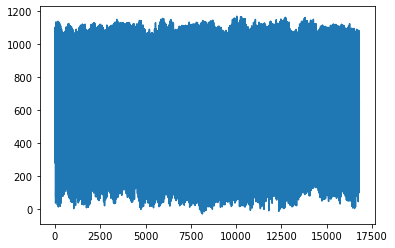

In [56]:
plt.plot(gru_outputs[0])
plt.show()

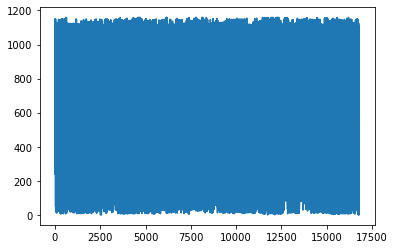

In [57]:
plt.plot(targets[0])
plt.show()